In [17]:
import numpy as np

from dipy.core.gradients import gradient_table
from dipy.data import default_sphere, get_fnames
from dipy.direction import DeterministicMaximumDirectionGetter
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti, load_nifti_data, save_nifti
from dipy.io.stateful_tractogram import Space, StatefulTractogram
from dipy.io.streamline import save_trk
from dipy.reconst.csdeconv import (ConstrainedSphericalDeconvModel,
                                   auto_response_ssst)
from dipy.reconst.shm import CsaOdfModel
from dipy.tracking import utils
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion
from dipy.tracking.streamline import Streamlines
from scipy.ndimage import binary_dilation
from dipy.viz import window, actor, colormap, has_fury

In [18]:
##### file paths
fidwi  = 'stanford_hardi/HARDI150.nii.gz'
fbval  = 'stanford_hardi/HARDI150.bval'
fbvec  = 'stanford_hardi/HARDI150.bvec'
filab  = 'stanford_hardi/aparc-reduced.nii.gz'
fit1w  = 'stanford_hardi/t1.nii.gz'

In [19]:
data, affine, hardi_img = load_nifti(fidwi, return_img=True)
labels = load_nifti_data(filab)
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals, bvecs)

# seed_mask = labels == 1

seed_mask = (labels == 1) #["Left-Cerebral-White-Matter","Right-Cerebral-White-Matter", "WM-hypointensities", "Optic-Chiasm", "ctx-lh-corpuscallosum", "ctx-rh-corpuscallosum" 
# seed_mask = (labels == 2) #["CC_Posterior", "CC_Mid_Posterior", "CC_Central", "CC_Mid_Anterior", "CC_Anterior"]

In [20]:
affine

array([[   2.,    0.,    0.,  -80.],
       [   0.,    2.,    0., -120.],
       [   0.,    0.,    2.,  -60.],
       [   0.,    0.,    0.,    1.]])

In [21]:
np.eye(4)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [22]:
white_matter = binary_dilation((labels == 1) | (labels == 2))
seeds = utils.seeds_from_mask(seed_mask, affine, density=1)

response, ratio = auto_response_ssst(gtab, data, roi_radii=10, fa_thr=0.7)

csd_model = ConstrainedSphericalDeconvModel(gtab, response, sh_order=6)
csd_fit = csd_model.fit(data, mask=white_matter)

csa_model = CsaOdfModel(gtab, sh_order=6)
gfa = csa_model.fit(data, mask=white_matter).gfa
stopping_criterion = ThresholdStoppingCriterion(gfa, .25)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96983/96983 [00:16<00:00, 5774.37it/s]


In [24]:
detmax_dg = DeterministicMaximumDirectionGetter.from_shcoeff(csd_fit.shm_coeff, max_angle=30., sphere=default_sphere)
streamline_generator = LocalTracking(detmax_dg, stopping_criterion, seeds, affine, step_size=.5)
streamlines = Streamlines(streamline_generator)

In [ ]:
# streamlines

In [1]:
# sft = StatefulTractogram(streamlines, hardi_img, Space.RASMM)
# save_trk(sft, "tractogram_deterministic_dg.trk")

In [25]:
interactive = True

In [26]:
if has_fury:
    scene = window.Scene()
    scene.add(actor.line(streamlines, colormap.line_colors(streamlines)))
    # window.record(scene, out_path='tractogram_deterministic_dg.png',
    #               size=(800, 800))
    if interactive:
        window.show(scene)

In [7]:
# ########## Connectivity and Path length
# from dipy.viz import actor, window, colormap as cmap
# from dipy.tracking.utils import path_length
# import numpy as np
# import matplotlib as mpl
# from mpl_toolkits.axes_grid1 import AxesGrid

In [15]:
### leaving space for connectivity

In [27]:
from dipy.viz import actor, window, colormap as cmap
from dipy.tracking.utils import path_length
import numpy as np
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import AxesGrid
from dipy.tracking.stopping_criterion import BinaryStoppingCriterion

In [28]:
# data, affine, hardi_img = load_nifti(fidwi, return_img=True)
# affine = affine
affine = np.eye(4)
seeds = utils.seeds_from_mask(white_matter, affine, density=1)
stopping_criterion = BinaryStoppingCriterion(white_matter)

streamline_generator = LocalTracking(detmax_dg, stopping_criterion, seeds,affine=affine, step_size=0.5)
streamlines = Streamlines(streamline_generator)

In [29]:
# cc_slice = labels == 1

# cc_slice = labels == 2

cc_slice  = (labels == 1) | (labels == 2)
cc_streamlines = utils.target(streamlines, affine, cc_slice)
cc_streamlines = Streamlines(cc_streamlines)

other_streamlines = utils.target(streamlines, affine, cc_slice, include=False)
other_streamlines = Streamlines(other_streamlines)
assert len(other_streamlines) + len(cc_streamlines) == len(streamlines)

In [30]:
interactive = True

In [31]:
streamlines

ArraySequence([array([[ 6.67629109, 41.99786495, 29.61893835],
       [ 7.        , 42.        , 30.        ],
       [ 7.43987263, 41.97193716, 30.23606047],
       [ 7.87974526, 41.94387433, 30.47212094],
       [ 8.15709588, 41.83525823, 30.87371673],
       [ 8.26287919, 41.73831863, 31.35268709]]), array([[ 6.82578055, 41.53312264, 29.95909625],
       [ 7.        , 42.        , 30.        ],
       [ 7.22122383, 42.44018733, 30.08541152],
       [ 7.39544329, 42.90706469, 30.12631527],
       [ 7.46165672, 43.40206485, 30.15061806],
       [ 7.52787015, 43.897065  , 30.17492085],
       [ 7.65391869, 44.38088406, 30.16936351],
       [ 7.7880187 , 44.85561541, 30.0878323 ],
       [ 7.86659038, 45.33327614, 29.96266554],
       [ 7.94516206, 45.81093687, 29.83749878],
       [ 7.96291409, 46.28304167, 29.67378586],
       [ 7.82405113, 46.76252453, 29.7023037 ],
       [ 7.84282642, 47.25300631, 29.60704033],
       [ 7.86160172, 47.74348809, 29.51177695],
       [ 7.9401734 , 48

In [32]:
M, grouping = utils.connectivity_matrix(cc_streamlines, affine,labels.astype(np.uint8), return_mapping=True, mapping_as_streamlines=True)

In [33]:
M.shape

(89, 89)

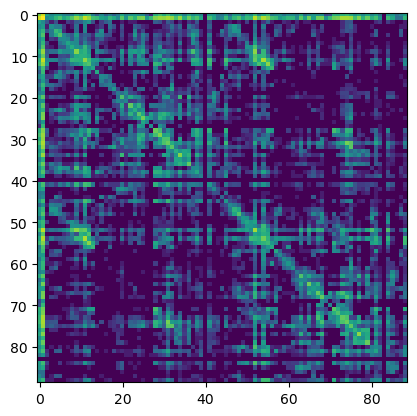

In [41]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(np.log1p(M), interpolation='nearest') 

In [36]:
##### the first 3 rows and colums are L WM , R WM and white matter intensities so we remove them.

M_copy = M.copy()

In [37]:
M_copy[:3, :] = 0
M_copy[:, :3] = 0

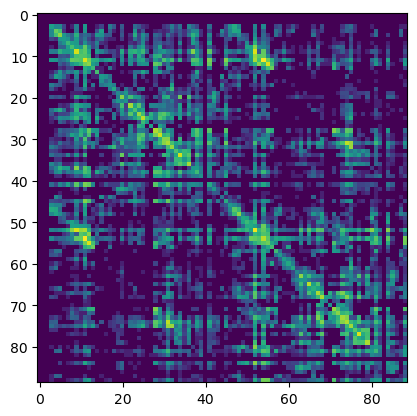

In [38]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(np.log1p(M_copy), interpolation='nearest') 

In [15]:
import pandas as pd

In [39]:
# Mdf = DF = pd.DataFrame(np.log1p(M_copy))

Morigdf = pd.DataFrame(np.log1p(M))

In [77]:
Mdf.to_csv('M_connectivity_deterministic.csv', header=False, index=False)

In [40]:
Morigdf.to_csv('Morig_connectivity_deterministic.csv', header=False, index=False)

In [27]:
#### path length

# Make a corpus callosum seed mask for tracking
seed_mask = labels == 2
seeds = utils.seeds_from_mask(seed_mask, affine, density=[1, 1, 1])

# Make a streamline bundle model of the corpus callosum ROI connectivity
streamlines = LocalTracking(detmax_dg, stopping_criterion, seeds, affine, step_size=0.5)
streamlines = Streamlines(streamlines)

In [28]:
streamlines_actor = actor.line(streamlines, cmap.line_colors(streamlines))
surface_opacity = 0.5
surface_color = [0, 1, 1]
seedroi_actor = actor.contour_from_roi(seed_mask, affine,  surface_color, surface_opacity)

scene = window.Scene()
scene.add(streamlines_actor)
scene.add(seedroi_actor)

In [29]:
interactive = True
if interactive:
    window.show(scene)

In [30]:
path_length_map_base_roi = seed_mask

# calculate the WMPL
wmpl = path_length(streamlines, affine, path_length_map_base_roi)

# save the WMPL as a nifti
save_nifti('example_cc_path_length_map_Det.nii.gz', wmpl.astype(np.float32),affine)

# get the T1 to show anatomical context of the WMPL
# t1_fname = get_fnames('stanford_t1')
t1_data = load_nifti_data(fit1w)

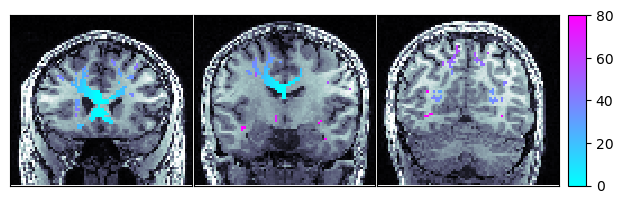

In [31]:
fig = mpl.pyplot.figure()
fig.subplots_adjust(left=0.05, right=0.95)
ax = AxesGrid(fig, 111, nrows_ncols=(1, 3), cbar_location="right", cbar_mode="single", cbar_size="10%", cbar_pad="5%")

wmpl_show = np.ma.masked_where(wmpl < 0, wmpl)

slx, sly, slz = [70, 55, 30]
ax[0].matshow(np.rot90(t1_data[:, slx, :]), cmap=mpl.cm.bone)
im = ax[0].matshow(np.rot90(wmpl_show[:, slx, :]),
                   cmap=mpl.cm.cool, vmin=0, vmax=80)

ax[1].matshow(np.rot90(t1_data[:, sly, :]), cmap=mpl.cm.bone)
im = ax[1].matshow(np.rot90(wmpl_show[:, sly, :]), cmap=mpl.cm.cool,
                   vmin=0, vmax=80)

ax[2].matshow(np.rot90(t1_data[:, slz, :]), cmap=mpl.cm.bone)
im = ax[2].matshow(np.rot90(wmpl_show[:, slz, :]),
                   cmap=mpl.cm.cool, vmin=0, vmax=80)

ax.cbar_axes[0].colorbar(im)
for lax in ax:
    lax.set_xticks([])
    lax.set_yticks([])